In [52]:
import logging
import pypsa
import os.path
import numpy as np  
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# running the jupyter notebook on the compute nodes doesnt build the path as expected, you have to manually do this
import IPython
import xarray as xr
working_directory = os.path.dirname(IPython.extract_module_locals()[1]['__vsc_ipynb_file__'])
workflow_dir = os.path.dirname(working_directory)
scripts_dir = os.path.join(workflow_dir, "scripts")
root_dir = os.path.dirname(workflow_dir)

os.chdir(scripts_dir)

# from make_summary import assign_carriers
from _helpers import configure_logging, mock_snakemake
from constants import PLOT_COST_UNITS, PLOT_CAP_UNITS,PLOT_SUPPLY_UNITS

logger = logging.getLogger(__name__)
PLANNING_YEAR = 2055
snakemake = mock_snakemake(
    "plot_network",
    snakefile_path=os.path.abspath("../"),
    topology="current+FCG",
    co2_pathway="exp175default",
    planning_horizons=PLANNING_YEAR,
    heating_demand="positive",
)

configure_logging(snakemake, logger=logger)
config = snakemake.config
tech_colors = config["plotting"]["tech_colors"]


ntw_path = snakemake.input.network
# ntw_path = f"/home/ivanra/downloads/PaperResultsXiaowei_networks/postnetwork-ll-current+Neighbor-exponential175-{PLANNING_YEAR}.nc"
ntw_path = "/p/tmp/yanleizh/PyPSA-China-PIK/results/v-0.2.0_test_co2_pr_baseline_0416_SD_withCB_dual/overnight_co2pw-exp175default_topo-current+FCG_proj-positive/postnetworks/ntwk_2060.nc"
n = pypsa.Network(ntw_path)
results_dir = os.path.dirname(os.path.dirname(ntw_path))
results_dir 


2025-06-18 09:16:21,966 - _helpers.py - INFO - =========== NEW RUN ===========
2025-06-18 09:16:21,966 - _helpers.py - INFO - =========== NEW RUN ===========
2025-06-18 09:16:21,966 - _helpers.py - INFO - =========== NEW RUN ===========
2025-06-18 09:16:21,966 - _helpers.py - INFO - =========== NEW RUN ===========
2025-06-18 09:16:21,966 - _helpers.py - INFO - =========== NEW RUN ===========
2025-06-18 09:16:21,966 - _helpers.py - INFO - =========== NEW RUN ===========
INFO:__main__:=========== NEW RUN ===========
INFO:pypsa.io:Imported network ntwk_2060.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores


'/p/tmp/yanleizh/PyPSA-China-PIK/results/v-0.2.0_test_co2_pr_baseline_0416_SD_withCB_dual/overnight_co2pw-exp175default_topo-current+FCG_proj-positive'

### Path setting

In [12]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# 新建 PDF 文件（只运行一次）
pdf_path = "justtry2.pdf"
pdf_pages = PdfPages(pdf_path)
STANDARD_FIGSIZE = (12, 7)  # 或 A4 landscape (11.69, 8.27)
def auto_sized_subplot_grid(n_panels, ncols=6, height_per_row=6, width=24):
    nrows = (n_panels + ncols - 1) // ncols
    figsize = (width, nrows * height_per_row)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    return fig, axes.flatten()


/p/tmp/yanleizh/PyPSA-China-PIK/workflow/scripts/_pypsa_helpers.py:108: RuntimeWarning: invalid value encountered in scalar divide
  profits["LCOE"] = profits.apply(lambda row: (row.CAPEX + row.OPEX)/row.supply, axis=1)
/p/tmp/yanleizh/PyPSA-China-PIK/workflow/scripts/_pypsa_helpers.py:110: RuntimeWarning: invalid value encountered in scalar divide
  lambda row: (row.CAPEX_wBROWN + row.OPEX)/row.supply, axis=1)
/p/tmp/yanleizh/PyPSA-China-PIK/workflow/scripts/_pypsa_helpers.py:111: RuntimeWarning: divide by zero encountered in scalar divide
  profits["MV"] = profits.apply(lambda row: row.Revenue/row.supply, axis=1)


component  carrier  location
Generator  nuclear  Shandong    0.884458
           onwind   Shandong    0.131562
           solar    Shandong    0.136771
dtype: float64

上限约束的每MWh对偶值统计:
Min: -0.0, Max: -0.0

下限约束的每MWh对偶值统计:
Min: 0.0, Max: 0.0

合并后的数据示例:

地区: Shandong
                                                OPEX         CAPEX  \
component   carrier                                                  
Generator   nuclear                     1.062482e+10  4.912702e+10   
            offwind                     0.000000e+00  1.320000e-03   
            onwind                      2.741478e+08  6.121841e+09   
            solar                       3.971338e+06  8.060199e+09   
Link        H2 Electrolysis             0.000000e+00  7.499162e+08   
            H2 fuel cell                0.000000e+00  1.711213e+09   
            Sabatier                    1.356219e+09  8.678725e+08   
            battery+battery discharger  0.000000e+00  7.782508e+08   
            gas OCGT              

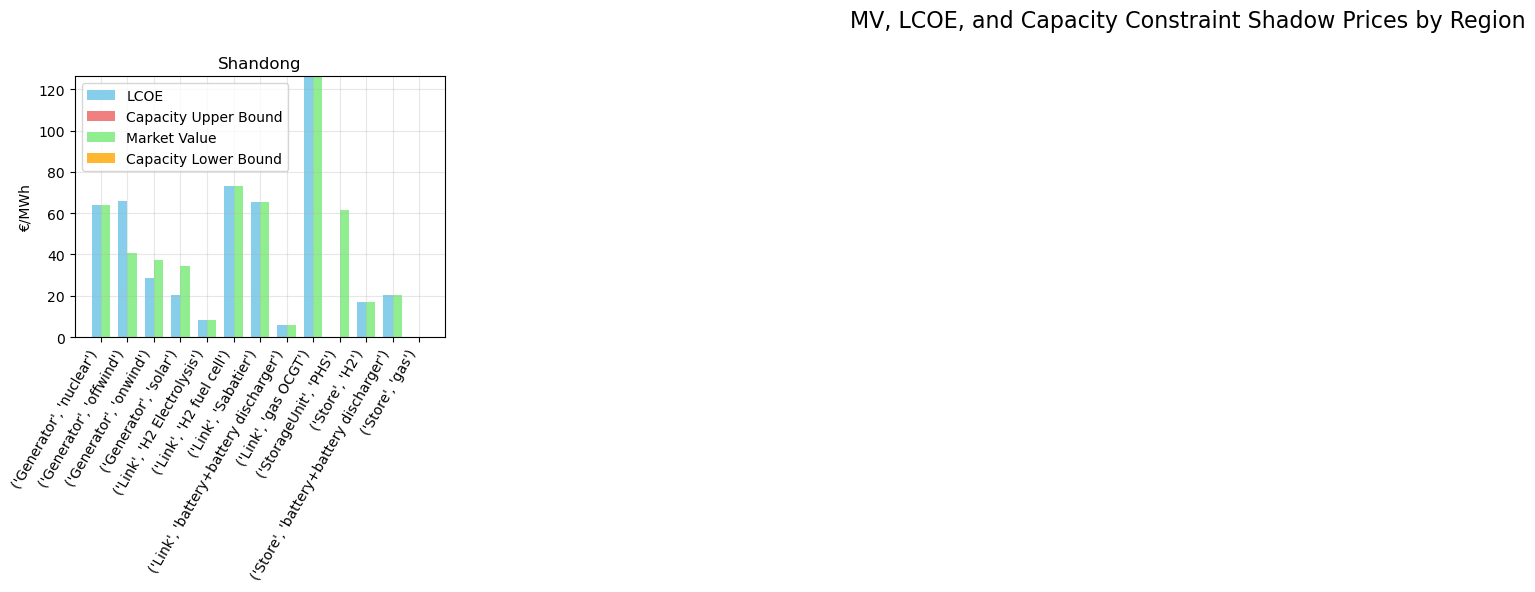

In [32]:
from _pypsa_helpers import calc_lcoe
# 获取 LCOE 和 MV 数据
df_lcoe_mv = calc_lcoe(n, groupby=["carrier", "location"])

# 方法1: 直接从xarray读取对偶变量
ds = xr.open_dataset(ntw_path)

# 获取上限和下限约束的对偶变量
shadow_price_upper_var = "generators_mu_ext-p_nom-upper"
shadow_price_lower_var = "generators_mu_ext-p_nom-lower"
# 创建空的DataFrame用于存储上限约束的对偶变量
dual_upper = pd.DataFrame(index=n.generators.index)
dual_upper["location"] = n.generators["location"]
dual_upper["carrier"] = n.generators["carrier"]
dual_upper["shadow_price_MW"] = 0.0  # 初始化为0

# 创建空的DataFrame用于存储下限约束的对偶变量
dual_lower = pd.DataFrame(index=n.generators.index)
dual_lower["location"] = n.generators["location"]
dual_lower["carrier"] = n.generators["carrier"]
dual_lower["shadow_price_MW"] = 0.0  # 初始化为0

# 处理上限约束的对偶变量 (negative values)
if shadow_price_upper_var in ds.variables:
    shadow_price_upper = ds[shadow_price_upper_var]
    shadow_upper_values = shadow_price_upper.values
    
    print(f"\n上限约束统计: shape={shadow_upper_values.shape}")
    print(f"非NaN值数量: {np.sum(~np.isnan(shadow_upper_values))}")
    print(f"Min: {np.nanmin(shadow_upper_values)}, Max: {np.nanmax(shadow_upper_values)}")
    
    # 将值添加到DataFrame
    if len(shadow_upper_values) == len(dual_upper.index):
        dual_upper["shadow_price_MW"] = shadow_upper_values
    else:
        print(f"形状不匹配: shadow_upper_values shape {shadow_upper_values.shape}, dual index shape {len(dual_upper.index)}")

# 处理下限约束的对偶变量 (positive values)
if shadow_price_lower_var in ds.variables:
    shadow_price_lower = ds[shadow_price_lower_var]
    shadow_lower_values = shadow_price_lower.values
    
    print(f"\n下限约束统计: shape={shadow_lower_values.shape}")
    print(f"非NaN值数量: {np.sum(~np.isnan(shadow_lower_values))}")
    print(f"Min: {np.nanmin(shadow_lower_values)}, Max: {np.nanmax(shadow_lower_values)}")

    # 将值添加到DataFrame
    if len(shadow_lower_values) == len(dual_lower.index):
        dual_lower["shadow_price_MW"] = shadow_lower_values
    else:
        print(f"形状不匹配: shadow_lower_values shape {shadow_lower_values.shape}, dual index shape {len(dual_lower.index)}")

# 设置多层索引
dual_upper = dual_upper.set_index(["carrier", "location"])
dual_lower = dual_lower.set_index(["carrier", "location"])

# 获取 annual generation hours
cf = n.statistics.capacity_factor(comps=["Generator"], groupby=["carrier", "location"])
print(cf)
hours = cf * 8760  # 年利用小时数

# 计算上限约束的每MWh对偶值
df_shadow_upper = dual_upper.join(hours.rename("hours"), how="inner")
df_shadow_upper["shadow_price_per_MWh_upper"] = df_shadow_upper.apply(
    lambda row: row["shadow_price_MW"] / (-max(row["hours"], 0.1)) if row["hours"] > 0 else 0, 
    axis=1
)

# 计算下限约束的每MWh对偶值 (注意这里符号不取反)
df_shadow_lower = dual_lower.join(hours.rename("hours"), how="inner")
df_shadow_lower["shadow_price_per_MWh_lower"] = df_shadow_lower.apply(
    lambda row: row["shadow_price_MW"] / (max(row["hours"], 0.1)) if row["hours"] > 0 else 0, 
    axis=1
)

# 打印一些诊断信息
print("\n上限约束的每MWh对偶值统计:")
print(f"Min: {df_shadow_upper['shadow_price_per_MWh_upper'].min()}, Max: {df_shadow_upper['shadow_price_per_MWh_upper'].max()}")
print("\n下限约束的每MWh对偶值统计:")
print(f"Min: {df_shadow_lower['shadow_price_per_MWh_lower'].min()}, Max: {df_shadow_lower['shadow_price_per_MWh_lower'].max()}")

# 合并所有数据
df_combined = df_lcoe_mv.copy()
df_combined = df_combined.join(df_shadow_upper["shadow_price_per_MWh_upper"], how="left").fillna(0)
df_combined = df_combined.join(df_shadow_lower["shadow_price_per_MWh_lower"], how="left").fillna(0)
# 重设索引，修改 carrier 名称
df_combined = df_combined.reset_index()

# 合并 battery charger 和 discharger 为 battery
def unify_battery(row):
    if row["carrier"] in ["battery", "battery discharger"]:
        return "battery+battery discharger"
    return row["carrier"]

df_combined["carrier"] = df_combined.apply(unify_battery, axis=1)

# 重新设置索引并合并数值
df_combined = df_combined.groupby(["component", "carrier", "location"]).sum(numeric_only=True)

# 输出每个地区每种技术的数值，帮助调试
print("\n合并后的数据示例:")
for loc in df_combined.index.get_level_values('location').unique()[:2]:  # 只显示前两个地区
    print(f"\n地区: {loc}")
    print(df_combined.xs(loc, level='location'))

# 绘图部分 - 修改堆叠逻辑
# 获取所有地区并排序（按平均 MV 排序）
mean_mv = df_combined["MV"].groupby("location").mean()
locations = mean_mv.sort_values(ascending=True).index

# 图布局参数
ncols = 5
nrows = (len(locations) + ncols - 1) // ncols
fig, axes = auto_sized_subplot_grid(len(locations), ncols=6)
axes = axes.flatten()

for i, loc in enumerate(locations):
    ax = axes[i]
    df_loc = df_combined.xs(loc, level="location")

    if df_loc.empty:
        ax.set_visible(False)
        continue

    # 横坐标统一顺序
    df_loc = df_loc.sort_index()
    x = np.arange(len(df_loc))
    width = 0.35

    # 绘制堆叠柱（LCOE + 上限约束shadow price）
    ax.bar(x - width/2, df_loc["LCOE"], width=width, label="LCOE", color="skyblue")
    ax.bar(x - width/2, df_loc["shadow_price_per_MWh_upper"], bottom=df_loc["LCOE"],
           width=width, label="Capacity Upper Bound", color="lightcoral")

    # 绘制堆叠柱（MV + 下限约束shadow price）
    ax.bar(x + width/2, df_loc["MV"], width=width, label="Market Value", color="lightgreen")
    ax.bar(x + width/2, df_loc["shadow_price_per_MWh_lower"], bottom=df_loc["MV"],
           width=width, label="Capacity Lower Bound", color="orange", alpha=0.8)

    ax.set_title(loc)
    ax.set_ylabel("€/MWh")
    ax.set_xticks(x)
    ax.set_xticklabels(df_loc.index, rotation=60, ha="right")
    
    # 只在第一个子图画图例，避免重复
    if i == 0:
        ax.legend()

    ax.grid(True, alpha=0.3)

    # 改进部分 ✅
    ax.tick_params(axis="x", labelrotation=60)
    for label in ax.get_xticklabels():
        label.set_ha("right")

# 删除多余子图
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
fig.suptitle("MV, LCOE, and Capacity Constraint Shadow Prices by Region", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])  # 留出 suptitle 空间
pdf_pages.savefig(fig)
plt.show()
plt.close(fig)

In [33]:
n.statistics.market_value(comps="Generator", groupby=["carrier", "location"])
n.generators[["marginal_cost", "p_nom", "p_nom_opt"]]
n.statistics.supply()


component    carrier           
Store        H2                    6.443595e+07
             battery               1.372213e+08
             gas                   3.274093e+07
StorageUnit  PHS                   2.382360e+06
Generator    nuclear               9.337395e+08
             offwind               2.000000e-05
             onwind                2.247113e+08
             solar                 3.971338e+08
Link         H2 Electrolysis       8.903486e+07
             H2 fuel cell          2.332651e+07
             Sabatier              3.390547e+07
             battery               1.372213e+08
             battery discharger    1.344488e+08
             gas OCGT              1.457935e+07
dtype: float64

In [54]:
import pandas as pd
import xarray as xr

ds = xr.open_dataset(ntw_path)
# 获取数据
data = ds["generators_mu_ext-p_nom-upper"].values
print(data)


[-10452.00891766     -0.         -17108.4222309              nan
             nan             nan]


In [49]:
import xarray as xr
import pandas as pd

# 1. 读取netCDF文件
ds = xr.open_dataset(ntw_path)

# 2. 获取对偶变量和相关信息
shadow_price = ds['stores_t_mu_energy_balance']
stores_location = ds.stores_location
stores_carrier = ds.stores_carrier

# 3. 获取stores的索引映射
stores_index = ds.stores_t_mu_energy_balance_i.values

# 4. 创建多层次DataFrame
# 首先转换时间序列数据
df = pd.DataFrame(
    shadow_price.values,
    index=ds.snapshots.values,
    columns=stores_index
)

# 5. 添加位置和载体信息
location_map = dict(zip(range(len(stores_location)), stores_location.values))
carrier_map = dict(zip(range(len(stores_carrier)), stores_carrier.values))

# 6. 创建结果DataFrame
results = pd.DataFrame({
    'location': [location_map[i] for i in range(len(stores_location))],
    'carrier': [carrier_map[i] for i in range(len(stores_carrier))],
})

# 7. 计算时间平均值
shadow_price_mean = df.mean()

print("数据概览:")
print("\n1. 时间维度:", df.shape[0])
print("2. 存储设施数量:", df.shape[1])
print("\n3. 每个存储设施的平均对偶变量值:")
for store_id in stores_index:
    location = location_map.get(store_id, 'Unknown')
    carrier = carrier_map.get(store_id, 'Unknown')
    mean_value = df[store_id].mean()
    print(f"Store {store_id} ({carrier} in {location}): {mean_value:.4f}")

# 8. 如果你想看时间序列
print("\n4. 时间序列数据示例（前5个时间点）:")
print(df.head())

# 9. 如果你想看特定位置和载体的值
print("\n5. 按位置和载体分组的平均值:")
results['mean_shadow_price'] = shadow_price_mean.values
print(results.groupby(['location', 'carrier'])['mean_shadow_price'].mean())

数据概览:

1. 时间维度: 1753
2. 存储设施数量: 3

3. 每个存储设施的平均对偶变量值:
Store Shandong gas Store (Unknown in Unknown): 94.4882
Store Shandong H2 Store (Unknown in Unknown): 32.7374
Store Shandong battery (Unknown in Unknown): 57.5865

4. 时间序列数据示例（前5个时间点）:
   Shandong gas Store  Shandong H2 Store  Shandong battery
0           94.488164          43.590531         32.032368
1           94.488164          43.590531         32.032368
2           94.488164          43.590531         11.613427
3           94.488164          43.590531         11.613427
4           94.488164          43.590531         33.367050

5. 按位置和载体分组的平均值:
location  carrier
Shandong  H2         32.737395
          battery    57.586545
          gas        94.488164
Name: mean_shadow_price, dtype: float64


In [17]:
# import pandas as pd
# import pypsa
# import pypsa
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

# n = pypsa.Network("/p/tmp/yanleizh/PyPSA-China-PIK/results/v-0.2.0_test_co2_pr_baseline_0416_SD_withCB_dual/overnight_co2pw-exp175default_topo-current+FCG_proj-positive/prenetworks/ntwk_2060.nc")
# n.optimize(assign_all_duals=True)

# duals = n.model.dual 
# import os.path

# # 指定保存路径
# output_dir = "./dual_values_export"
# os.makedirs(output_dir, exist_ok=True)

# for name in n.model.dual.data_vars:
#     try:
#         dual = n.model.dual[name]
        
#         if hasattr(dual, "to_pandas"):
#             df = dual.to_pandas()
#         else:
#             df = pd.DataFrame({"dual_value": [dual.item()]})
        
#         df.to_csv(os.path.join(output_dir, f"{name}.csv"))
#         print(f"✅ Saved: {name}.csv")
#     except Exception as e:
#         print(f"⚠️ Failed to process {name}: {e}")

# def calc_lcoe(n: pypsa.Network, grouper=pypsa.statistics.get_carrier_and_bus_carrier, **kwargs
#               ) -> pd.DataFrame:
#     """calculate the LCOE for the network: (capex+opex)/supply.

#     Args:
#         n (pypsa.Network): the network for which LCOE is to be calaculated
#         grouper (function | list, optional): function to group the data in network.statistics.
#                 Overwritten if groupby is passed in kwargs.
#                 Defaults to pypsa.statistics.get_carrier_and_bus_carrier.
#         **kwargs: other arguments to be passed to network.statistics
#     Returns:
#         pd.DataFrame: The LCOE for the network  with or without brownfield CAPEX. MV and delta

#     """
#     if "groupby" in kwargs:
#         grouper = kwargs.pop("groupby")

#     rev = n.statistics.revenue(groupby=grouper, **kwargs)
#     opex = n.statistics.opex(groupby=grouper, **kwargs)
#     capex = n.statistics.expanded_capex(groupby=grouper, **kwargs)
#     tot_capex = n.statistics.capex(groupby=grouper, **kwargs)
#     supply = n.statistics.supply(groupby=grouper, **kwargs)

#     profits = pd.concat(
#         [opex, capex, tot_capex, rev, supply],
#         axis=1,
#         keys=["OPEX", "CAPEX", "CAPEX_wBROWN", "Revenue", "supply"]
#         ).fillna(0)
#     profits["rev-costs"] = profits.apply(lambda row: row.Revenue-row.CAPEX-row.OPEX, axis=1)
#     profits["LCOE"] = profits.apply(lambda row: (row.CAPEX + row.OPEX)/row.supply, axis=1)
#     profits["LCOE_wbrownfield"] = profits.apply(
#         lambda row: (row.CAPEX_wBROWN + row.OPEX)/row.supply, axis=1)
#     profits["MV"] = profits.apply(lambda row: row.Revenue/row.supply, axis=1)
#     profits["profit_pu"] = profits["rev-costs"]/profits.supply
#     profits.sort_values("profit_pu", ascending=False, inplace=True)

#     return profits[profits.supply > 0]

# market_value_diff = n.generators_t.mu_upper
# # print(n.statistics.capacity_factor()*8760)
# # 1. 获取 shadow price 对偶变量（Generator-  ext-p_nom-upper）
# # 获取 shadow price（是一个 Series）
# # 1. 从 CSV 加载 shadow price
# dual_raw = pd.read_csv("dual_values_export/Generator-ext-p_nom-upper.csv", index_col=0)

# # 2. 获取 capacity factor（按 carrier 和 location 分组）
# cf = n.statistics.capacity_factor(comps=["Generator"], groupby=["carrier", "location"])

# # 3. 年利用小时数
# hours = cf * 8760  # 单位：小时

# # 4. 解析 dual 的 index，形成 carrier-location 结构
# index_df = dual_raw.index.str.extract(r'(?P<location>.+)\s(?P<carrier>.+)')

# # 5. 构建 dual DataFrame 并设置索引
# dual = pd.DataFrame({
#     "location": index_df["location"],
#     "carrier": index_df["carrier"],
#     "shadow_price_MW": dual_raw.iloc[:, 0].values  # 第一列就是值
# }).set_index(["carrier", "location"])

# # 6. 合并利用小时数并计算边际值
# df = dual.join(hours.rename("hours"))
# df["shadow_price_per_MWh"] = df["shadow_price_MW"] / -df["hours"]

# # 7. 输出结果
# print(df.round( 3))


# # 获取 LCOE 和 MV 数据
# df = calc_lcoe(n, groupby=["carrier", "location"])
# print(df["profit_pu"])

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import random

# --- Data Preparation ---
capacity = n.statistics.optimal_capacity(groupby=["carrier", "location"]) / 1e3  # GW
generation = n.statistics.supply(groupby=["carrier", "location"]) / 1e6  # TWh

df_cap = capacity.unstack("carrier").fillna(0)
df_gen = generation.unstack("carrier").fillna(0)

df_cap_generator = df_cap.loc["Generator"]
df_gen_generator = df_gen.loc["Generator"]

df_cap_grouped = df_cap_generator.groupby("location").sum()
df_gen_grouped = df_gen_generator.groupby("location").sum()

# 获取在容量和发电量数据中都存在的carriers
common_carriers = list(set(df_cap_grouped.columns) & set(df_gen_grouped.columns))

# 修改这部分代码，为没有颜色的技术设置随机颜色
tech_colors = config["plotting"]["tech_colors"]

# 为没有预定义颜色的技术生成随机颜色
for carrier in common_carriers:
    if carrier not in tech_colors:
        random_color = '#%02X%02X%02X' % (
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255)
        )
        tech_colors[carrier] = random_color

# 使用更新后的颜色映射
colors = [tech_colors[c] for c in common_carriers]

# 只使用共同的carriers
df_cap_plot = df_cap_grouped[common_carriers]
df_gen_plot = df_gen_grouped[common_carriers]

# --- Plotting ---
fig, axes = plt.subplots(2, 1, figsize=(11.69, 10), sharex=True, gridspec_kw={"hspace": 0.3})

# Main title
fig.suptitle("Optimal Capacity and Generation by Technology", fontsize=16, y=0.98)

# Top plot: Installed capacity
df_cap_plot.plot(kind="bar", stacked=True, ax=axes[0], color=colors)
axes[0].set_title("Optimal Capacity (GW)", fontsize=13)
axes[0].set_ylabel("GW")
axes[0].legend(title="Technology", bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=10, title_fontsize=11)

# Bottom plot: Generation
df_gen_plot.plot(kind="bar", stacked=True, ax=axes[1], color=colors)
axes[1].set_title("Annual Generation (TWh)", fontsize=13)
axes[1].set_ylabel("TWh")
axes[1].set_xticklabels(df_cap_plot.index, rotation=45, ha="right")
axes[1].legend().remove()

# Layout adjustments
plt.subplots_adjust(top=0.90, bottom=0.1)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save to PDF
pdf_pages.savefig(fig)
plt.close(fig)

/p/tmp/yanleizh/anaconda/ipykernel_4104319/2255581575.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- 统计数据 ---
capex_ = n.statistics.expanded_capex().sum()
installed_capex_ = n.statistics.installed_capex().sum()
opex_ = n.statistics.opex().sum()
em_price_gas = float(n.statistics.supply(comps="Generator")["gas"]*n.global_constraints.at["co2_limit", "mu"]*0.2/-0.43)
print(f"{em_price_gas:.2e}")
costs_ = pd.DataFrame({
    "OPEX": opex_,
    "CAPEX": capex_,
    "CO2_cost": em_price_gas,
    "total": capex_ + installed_capex_ + opex_ + em_price_gas,
}, index=["Costs"]).stack()

revenue_ = n.statistics.revenue(comps="Load", bus_carrier="AC").sum()
costs_.loc[("Revenue", "AC")] = -revenue_

# --- 组合成 DataFrame ---
all_ = pd.concat({"2060 nobudget": costs_}, names=["CO2 control"])
all_.index.names = ["CO2 control", "Cat", "Type"]
all_ = pd.DataFrame(all_, columns=["Value"]).reset_index()

# --- 画图 ---
g = sns.catplot(data=all_, x="Cat", y="Value", hue="Type", col="CO2 control",
                kind="bar", dodge=True, alpha=0.8)

# 添加图标题（可选）
g.fig.suptitle("Total cost and revenue", fontsize=14, y=1.05)

# 保存到 PDF（你之前初始化的 pdf_pages）
pdf_pages.savefig(g.fig)
plt.close(g.fig)
n.global_constraints.at["co2_limit", "mu"]
gcon = n.global_constraints

columns_to_check = ["constant", "mu", "value"]
existing_columns = [col for col in columns_to_check if col in gcon.columns]

if "co2_limit" in gcon.index and existing_columns:
    print(gcon.loc["co2_limit", existing_columns])
else:
    print("⚠️ CO2 constraint or expected columns not found.")



0.00e+00
constant           0.0
mu         -628.043733
Name: co2_limit, dtype: object


                                         Revenue (€/year)  CAPEX (€/year)  \
component   carrier            location                                     
Generator   nuclear            Shandong      5.975184e+10    4.912702e+10   
            offwind            Shandong      8.100000e-04    1.320000e-03   
            onwind             Shandong      8.432761e+09    6.121841e+09   
            solar              Shandong      1.373180e+10    8.060199e+09   
Link        H2 Electrolysis    Shandong      7.499162e+08    7.499162e+08   
            H2 fuel cell       Shandong      1.711213e+09    1.711213e+09   
            Sabatier           Shandong      2.224091e+09    8.678725e+08   
            battery            Shandong      7.782508e+08    7.782508e+08   
            battery discharger Shandong      2.070000e-03    0.000000e+00   
            gas OCGT           Shandong      1.840906e+09    1.775299e+09   
Load                           Shandong     -9.324834e+10    0.000000e+00   

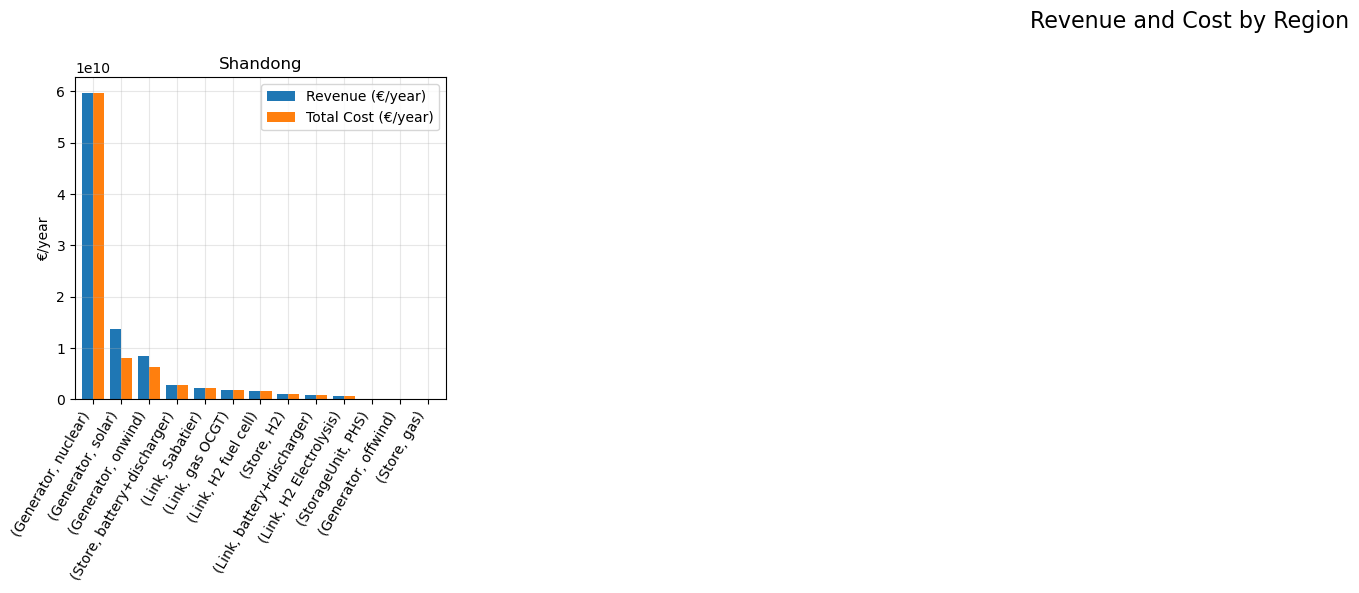

In [20]:
# 指定分组维度
groupby = ["carrier", "location"]

# 获取三项数据
capex = n.statistics.expanded_capex(groupby=groupby)
opex = n.statistics.opex(groupby=groupby)
revenue = n.statistics.revenue(groupby=groupby)

# 获取完整索引：三个 Series 的 index 的并集
full_index = capex.index.union(opex.index).union(revenue.index)

# 对齐所有数据到完整索引，并填补 NaN 为 0
capex = capex.reindex(full_index, fill_value=0)
opex = opex.reindex(full_index, fill_value=0)
revenue = revenue.reindex(full_index, fill_value=0)

# 计算 total cost 和 profit
total_cost = capex + opex
profit = revenue - total_cost

# 汇总成 DataFrame
comparison = pd.DataFrame({
    "Revenue (€/year)": revenue,
    "CAPEX (€/year)": capex,
    "OPEX (€/year)": opex,
    "Total Cost (€/year)": total_cost,
    "Profit (€/year)": profit,
})
print(comparison)
comparison = comparison[comparison.index.get_level_values("component") != "Load"]
# 重设索引，修改 carrier 名称
comparison = comparison.reset_index()

# 合并 battery charger 和 discharger 为 battery
def unify_battery(row):
    if row["carrier"] in ["battery", "battery discharger"]:
        return "battery+discharger"
    return row["carrier"]

comparison["carrier"] = comparison.apply(unify_battery, axis=1)

# 重新设置索引并合并数值
comparison = comparison.groupby(["component", "carrier", "location"]).sum(numeric_only=True)

# 可视化：按地区分子图
import matplotlib.pyplot as plt

# 获取所有地区
locations = comparison.index.get_level_values("location").unique()
ncols = 5
nrows = (len(locations) + ncols - 1) // ncols

fig, axes = auto_sized_subplot_grid(len(locations), ncols=6)
axes = axes.flatten()

for i, loc in enumerate(locations):
    ax = axes[i]
    df_loc = comparison.xs(loc, level="location")

    # 如果该地区为空则跳过
    if df_loc.empty:
        ax.set_visible(False)
        continue

    # 排序（这里可按 revenue 或 profit）
    df_loc = df_loc.sort_values("Revenue (€/year)", ascending=False)

    # 绘图
    df_loc[["Revenue (€/year)", "Total Cost (€/year)"]].plot(
        kind="bar", ax=ax, width=0.8
    )

    ax.set_title(f"{loc}")
    ax.set_xlabel("")
    ax.set_ylabel("€/year")
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis="x", labelrotation=45)
    # 改进部分 ✅
    ax.tick_params(axis="x", labelrotation=60)
    for label in ax.get_xticklabels():
        label.set_ha("right")
# 移除多余子图
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 添加统一图例
handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc="RIGHTER", bbox_to_anchor=(0.5, 1.02), ncol=1)
fig.suptitle("Revenue and Cost by Region", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])  # 留出 suptitle 空间
plt.show()
pdf_pages.savefig(fig)
plt.close(fig)



In [21]:
# # import sys
# # sys.path.append("../scripts")

# from _pypsa_helpers import calc_lcoe
# # 获取 LCOE 和 MV 数据
# # 获取 LCOE 和 MV 数据
# df_lcoe_mv = calc_lcoe(n, groupby=["carrier", "location"])

# # 获取 shadow price 数据
# dual_array = n.model.dual["Generator-ext-p_nom-upper"]
# dual_series = dual_array.to_pandas()
# index_df = dual_series.index.to_series().str.extract(r'(?P<location>.+)\s(?P<carrier>.+)')
# dual = pd.DataFrame({
#     "location": index_df["location"],
#     "carrier": index_df["carrier"],
#     "shadow_price_MW": dual_series.values
# }).set_index(["carrier", "location"])

# # 获取 annual generation hours
# cf = n.statistics.capacity_factor(comps=["Generator"], groupby=["carrier", "location"])
# hours = cf * 8760  # 年利用小时数

# # 合并并计算每度电的 shadow price
# df_shadow = dual.join(hours.rename("hours"))
# df_shadow["shadow_price_per_MWh"] = df_shadow["shadow_price_MW"] / -df_shadow["hours"]

# # 合并 LCOE 和 shadow price 数据
# df_combined = df_lcoe_mv.join(df_shadow["shadow_price_per_MWh"], how="left").fillna(0)

# # 获取所有地区并排序（按平均 MV 排序）
# mean_mv = df_combined["MV"].groupby("location").mean()
# locations = mean_mv.sort_values(ascending=True).index

# # 图布局参数
# ncols = 5
# nrows = (len(locations) + ncols - 1) // ncols
# fig, axes = auto_sized_subplot_grid(len(locations), ncols=6)
# axes = axes.flatten()

# for i, loc in enumerate(locations):
#     ax = axes[i]
#     df_loc = df_combined.xs(loc, level="location")

#     if df_loc.empty:
#         ax.set_visible(False)
#         continue

#     # 横坐标统一顺序
#     df_loc = df_loc.sort_index()
#     x = np.arange(len(df_loc))
#     width = 0.35

#     # 绘制堆叠柱（LCOE + shadow price）
#     ax.bar(x - width/2, df_loc["LCOE"], width=width, label="LCOE", color="skyblue")
#     ax.bar(x - width/2, df_loc["shadow_price_per_MWh"], bottom=df_loc["LCOE"],
#            width=width, label="Shadow Price", color="lightcoral")

#     # 绘制 MV 柱（不堆叠）
#     ax.bar(x + width/2, df_loc["MV"], width=width, label="Market Value", color="lightgreen", alpha=0.8)

#     ax.set_title(loc)
#     ax.set_ylabel("€/MWh")
#     ax.set_xticks(x)
#     ax.set_xticklabels(df_loc.index, rotation=60, ha="right")
    
#     # 只在第一个子图画图例，避免重复
#     if i == 0:
#         ax.legend()

#     ax.grid(True, alpha=0.3)

#     # 改进部分 ✅
#     ax.tick_params(axis="x", labelrotation=60)
#     for label in ax.get_xticklabels():
#         label.set_ha("right")

# # 删除多余子图
# for j in range(i+1, len(axes)):
#     fig.delaxes(axes[j])
# fig.suptitle("MV, LCOE, and Shadow Price by Region", fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.99])  # 留出 suptitle 空间
# pdf_pages.savefig(fig)
# plt.show()
# plt.close(fig)

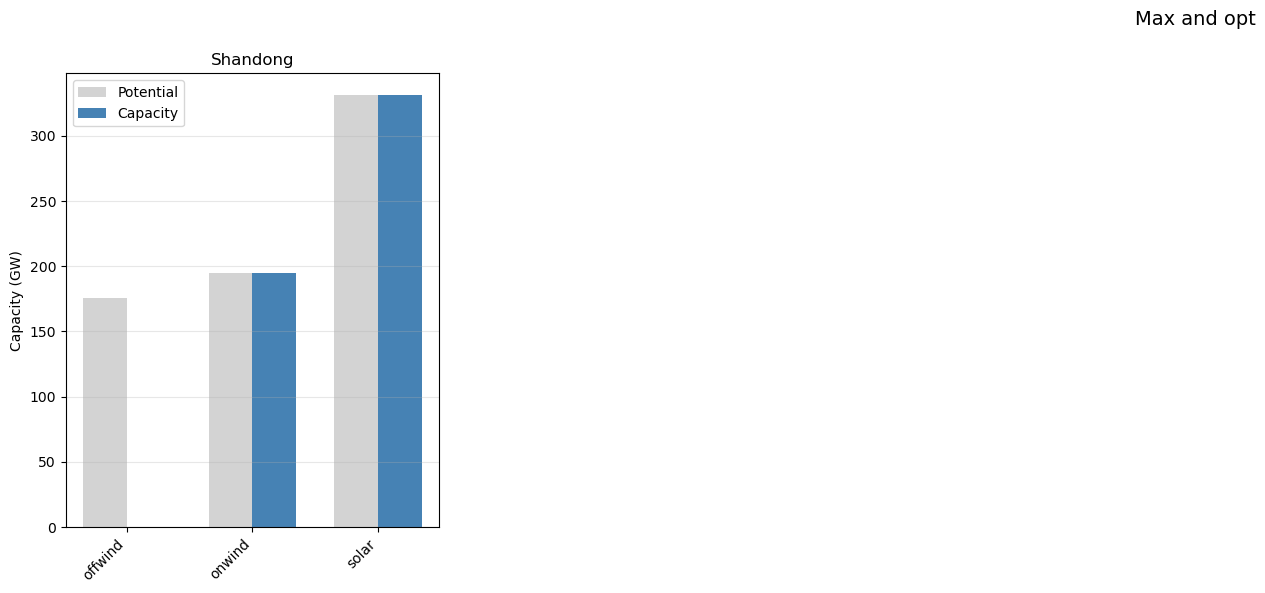

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 实际容量 ---
df_opt = n.statistics.optimal_capacity(comps="Generator", groupby=["location", "carrier"]) / 1e3
df_opt = df_opt.unstack().fillna(0)
df_opt[df_opt < 1e-3] = 0

# --- 最大容量 ---
gen = n.generators.copy()
gen = gen[gen.p_nom_extendable]
df_max = gen.groupby(["location", "carrier"])["p_nom_max"].sum().unstack().fillna(0) / 1e3

# 记录哪些位置是 inf
mask_inf = gen.groupby(["location", "carrier"])["p_nom_max"].max().unstack()
mask_inf = mask_inf == np.inf

# 在 df_max 和 df_opt 中都移除这些 inf 技术
for loc in mask_inf.index:
    if loc in df_max.index:
        drop_carriers = mask_inf.columns[mask_inf.loc[loc]]
        df_max.loc[loc, drop_carriers] = np.nan
        df_opt.loc[loc, drop_carriers] = np.nan

df_max = df_max.fillna(0)
df_opt = df_opt.fillna(0)

# --- 对齐 ---
all_locations = sorted(set(df_opt.index) | set(df_max.index))
all_carriers = sorted(set(df_opt.columns) | set(df_max.columns))

df_opt = df_opt.reindex(index=all_locations, columns=all_carriers).fillna(0)
df_max = df_max.reindex(index=all_locations, columns=all_carriers).fillna(0)

# --- 排序 ---
locations = df_opt.sum(axis=1).sort_values().index

# --- 绘图 ---
ncols = 5
nrows = (len(locations) + ncols - 1) // ncols
fig, axes = auto_sized_subplot_grid(len(locations), ncols=6)
axes = axes.flatten()

for i, loc in enumerate(locations):
    ax = axes[i]
    y_max = df_max.loc[loc]
    y_opt = df_opt.loc[loc]

    # 只保留该地区“有限”的技术
    mask = (y_max > 0) | (y_opt > 0)
    y_max = y_max[mask]
    y_opt = y_opt[mask]
    carriers = y_max.index.tolist()

    if len(carriers) == 0:
        ax.set_visible(False)
        continue

    x = range(len(carriers))
    width = 0.35

    ax.bar([xi - width/2 for xi in x], y_max.values, width=width, color="lightgray", label="Potential")
    ax.bar([xi + width/2 for xi in x], y_opt.values, width=width, color="steelblue", label="Capacity")

    ax.set_title(loc)
    ax.set_xticks(x)
    ax.set_xticklabels(carriers, rotation=45, ha="right")
    ax.set_ylabel("Capacity (GW)")
    ax.grid(True, axis="y", alpha=0.3)

    if i == 0:
        ax.legend()

# 删除多余子图
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
fig.suptitle("Max and opt", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.99])  # 留出 suptitle 空间
plt.show()
pdf_pages.savefig(fig)
plt.close(fig)


lower

In [23]:
n.global_constraints



,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
co2_limit,primary_energy,NaN,co2_emissions,<=,0.0,-628.043733


In [24]:
pdf_pages.close()
print("✅ 所有图已写入 PDF 文件！")


✅ 所有图已写入 PDF 文件！
